In [ ]:
# LatticeBoltzmannDemo.py:  a two-dimensional lattice-Boltzmann "wind tunnel" simulation
# Uses numpy to speed up all array handling.
# Uses matplotlib to plot and animate the curl of the macroscopic velocity field.

# Copyright 2013, Daniel V. Schroeder (Weber State University) 2013

# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated data and documentation (the "Software"), to deal in 
# the Software without restriction, including without limitation the rights to 
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
# of the Software, and to permit persons to whom the Software is furnished to do 
# so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all 
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
# PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR 
# ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR 
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
# OTHER DEALINGS IN THE SOFTWARE.

# Except as contained in this notice, the name of the author shall not be used in 
# advertising or otherwise to promote the sale, use or other dealings in this 
# Software without prior written authorization.

# Credits:
# The "wind tunnel" entry/exit conditions are inspired by Graham Pullan's code
# (http://www.many-core.group.cam.ac.uk/projects/LBdemo.shtml).  Additional inspiration from 
# Thomas Pohl's applet (http://thomas-pohl.info/work/lba.html).  Other portions of code are based 
# on Wagner (http://www.ndsu.edu/physics/people/faculty/wagner/lattice_boltzmann_codes/) and
# Gonsalves (http://www.physics.buffalo.edu/phy411-506-2004/index.html; code adapted from Succi,
# http://global.oup.com/academic/product/the-lattice-boltzmann-equation-9780199679249).

# For related materials see http://physics.weber.edu/schroeder/fluids


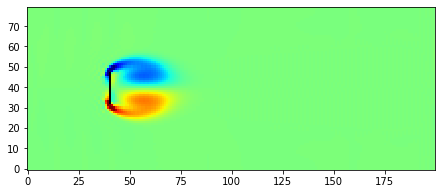

In [9]:

import numpy, time, matplotlib.pyplot, matplotlib.animation

# Define constants:
height = 80							# lattice dimensions
width = 200
viscosity = 0.02					# fluid viscosity
omega = 1 / (3*viscosity + 0.5)		# "relaxation" parameter
u0 = 0.1							# initial and in-flow speed
four9ths = 4.0/9.0					# abbreviations for lattice-Boltzmann weight factors
one9th   = 1.0/9.0
one36th  = 1.0/36.0
performanceData = True				# set to True if performance data is desired

# Initialize all the arrays to steady rightward flow:
n0 = four9ths * (numpy.ones((height,width)) - 1.5*u0**2)	# particle densities along 9 directions
nN = one9th * (numpy.ones((height,width)) - 1.5*u0**2)
nS = one9th * (numpy.ones((height,width)) - 1.5*u0**2)
nE = one9th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nW = one9th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNE = one36th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSE = one36th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNW = one36th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSW = one36th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW		# macroscopic density
ux = (nE + nNE + nSE - nW - nNW - nSW) / rho				# macroscopic x velocity
uy = (nN + nNE + nNW - nS - nSE - nSW) / rho				# macroscopic y velocity

# Initialize barriers:
barrier = numpy.zeros((height,width), bool)					# True wherever there's a barrier
barrier[int((height/2)-8):int((height/2)+8), int(height/2)] = True			# simple linear barrier
barrierN = numpy.roll(barrier,  1, axis=0)					# sites just north of barriers
barrierS = numpy.roll(barrier, -1, axis=0)					# sites just south of barriers
barrierE = numpy.roll(barrier,  1, axis=1)					# etc.
barrierW = numpy.roll(barrier, -1, axis=1)
barrierNE = numpy.roll(barrierN,  1, axis=1)
barrierNW = numpy.roll(barrierN, -1, axis=1)
barrierSE = numpy.roll(barrierS,  1, axis=1)
barrierSW = numpy.roll(barrierS, -1, axis=1)

# Move all particles by one step along their directions of motion (pbc):
def stream():
	global nN, nS, nE, nW, nNE, nNW, nSE, nSW
	nN  = numpy.roll(nN,   1, axis=0)	# axis 0 is north-south; + direction is north
	nNE = numpy.roll(nNE,  1, axis=0)
	nNW = numpy.roll(nNW,  1, axis=0)
	nS  = numpy.roll(nS,  -1, axis=0)
	nSE = numpy.roll(nSE, -1, axis=0)
	nSW = numpy.roll(nSW, -1, axis=0)
	nE  = numpy.roll(nE,   1, axis=1)	# axis 1 is east-west; + direction is east
	nNE = numpy.roll(nNE,  1, axis=1)
	nSE = numpy.roll(nSE,  1, axis=1)
	nW  = numpy.roll(nW,  -1, axis=1)
	nNW = numpy.roll(nNW, -1, axis=1)
	nSW = numpy.roll(nSW, -1, axis=1)
	# Use tricky boolean arrays to handle barrier collisions (bounce-back):
	nN[barrierN] = nS[barrier]
	nS[barrierS] = nN[barrier]
	nE[barrierE] = nW[barrier]
	nW[barrierW] = nE[barrier]
	nNE[barrierNE] = nSW[barrier]
	nNW[barrierNW] = nSE[barrier]
	nSE[barrierSE] = nNW[barrier]
	nSW[barrierSW] = nNE[barrier]
		
# Collide particles within each cell to redistribute velocities (could be optimized a little more):
def collide():
	global rho, ux, uy, n0, nN, nS, nE, nW, nNE, nNW, nSE, nSW
	rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
	ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
	uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
	ux2 = ux * ux				# pre-compute terms used repeatedly...
	uy2 = uy * uy
	u2 = ux2 + uy2
	omu215 = 1 - 1.5*u2			# "one minus u2 times 1.5"
	uxuy = ux * uy
	n0 = (1-omega)*n0 + omega * four9ths * rho * omu215
	nN = (1-omega)*nN + omega * one9th * rho * (omu215 + 3*uy + 4.5*uy2)
	nS = (1-omega)*nS + omega * one9th * rho * (omu215 - 3*uy + 4.5*uy2)
	nE = (1-omega)*nE + omega * one9th * rho * (omu215 + 3*ux + 4.5*ux2)
	nW = (1-omega)*nW + omega * one9th * rho * (omu215 - 3*ux + 4.5*ux2)
	nNE = (1-omega)*nNE + omega * one36th * rho * (omu215 + 3*(ux+uy) + 4.5*(u2+2*uxuy))
	nNW = (1-omega)*nNW + omega * one36th * rho * (omu215 + 3*(-ux+uy) + 4.5*(u2-2*uxuy))
	nSE = (1-omega)*nSE + omega * one36th * rho * (omu215 + 3*(ux-uy) + 4.5*(u2-2*uxuy))
	nSW = (1-omega)*nSW + omega * one36th * rho * (omu215 + 3*(-ux-uy) + 4.5*(u2+2*uxuy))
	# Force steady rightward flow at ends (no need to set 0, N, and S components):
	nE[:,0] = one9th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nW[:,0] = one9th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nNE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nSE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nNW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nSW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

# Compute curl of the macroscopic velocity field:
def curl(ux, uy):
	return numpy.roll(uy,-1,axis=1) - numpy.roll(uy,1,axis=1) - numpy.roll(ux,-1,axis=0) + numpy.roll(ux,1,axis=0)

# Here comes the graphics and animation...
theFig = matplotlib.pyplot.figure(figsize=(8,3))
fluidImage = matplotlib.pyplot.imshow(curl(ux, uy), origin='lower', norm=matplotlib.pyplot.Normalize(-.1,.1), 
									cmap=matplotlib.pyplot.get_cmap('jet'), interpolation='none')
		# See http://www.loria.fr/~rougier/teaching/matplotlib/#colormaps for other cmap options
bImageArray = numpy.zeros((height, width, 4), numpy.uint8)	# an RGBA image
bImageArray[barrier,3] = 255								# set alpha=255 only at barrier sites
barrierImage = matplotlib.pyplot.imshow(bImageArray, origin='lower', interpolation='none')

# Function called for each successive animation frame:
startTime = time.time()
#frameList = open('frameList.txt','w')		# file containing list of images (to make movie)
def nextFrame(arg):							# (arg is the frame number, which we don't need)
	global startTime
	if performanceData and (arg%100 == 0) and (arg > 0):
		endTime = time.time()
		print ("%1.1f" % (100/(endTime-startTime)), 'frames per second')
		startTime = endTime
	#frameName = "frame%04d.png" % arg
	#matplotlib.pyplot.savefig(frameName)
	#frameList.write(frameName + '\n')
	for step in range(500):					# adjust number of steps for smooth animation
		stream()
		collide()
	fluidImage.set_array(curl(ux, uy))
	return (fluidImage, barrierImage)		# return the figure elements to redraw

animate = matplotlib.animation.FuncAnimation(theFig, nextFrame, interval=1, blit=True)
matplotlib.pyplot.show()

In [4]:
(height/2)-8,(height/2)+8

(32.0, 48.0)

100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]



 U velocity is: 
[[-0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.00000000e+00]
 [-1.12398467e-03  1.12398467e-03  1.92099143e-03 ... -2.48767190e-02
   2.62485787e-01  1.73751421e+00]
 [-1.63077723e-03  1.63077723e-03  3.25324795e-03 ...  6.44116686e-02
   4.78346267e-01  1.52165373e+00]
 ...
 [-6.56065795e-04  6.56065795e-04  1.30798221e-03 ...  1.41899364e-01
   5.37988576e-01  1.46201142e+00]
 [-3.90385873e-04  3.90385873e-04  7.03354451e-04 ...  6.23552130e-03
   2.96275985e-01  1.70372401e+00]
 [-0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.00000000e+00]]

 V velocity is: 
[[ 0.00000000e+00 -1.10163267e-03 -1.48001950e-03 ... -2.34221815e-01
  -2.60741346e-01  0.00000000e+00]
 [ 0.00000000e+00  1.10163267e-03  1.48001950e-03 ...  2.34221815e-01
   2.60741346e-01  0.00000000e+00]
 [ 0.00000000e+00  1.78789390e-03  2.78777909e-03 ...  3.01980011e-01
   2.14254808e-01  0.00000000e+00]
 ...
 [ 0.000

TypeError: Length of x (101) must match number of columns in z (102)

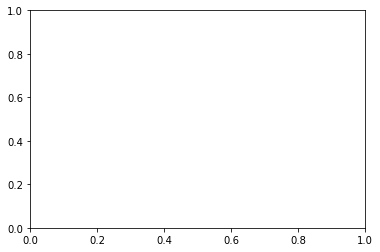

In [1]:
# The lid-driven cavity problem has long been used a test or validation case for new codes or new solution methods.
# The standard case is fluid contained in a square domain with Dirichlet boundary conditions on all sides, with three
# stationary sides and one moving side (with velocity tangent to the side).

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
# Define parameters
x_len = 1.0
y_len = 1.0
x_points = 101
y_points = 101
del_x = x_len/float(x_points)
del_y = y_len/float(y_points)
del_t = 0.001                       # Keep small time steps
num_itrs = 1000
delta = 4.5
Re = 100
U_boundary = 1.0

u = np.zeros((x_points, y_points+1))
v = np.zeros((x_points+1, y_points))
p = np.ones((x_points+1, y_points+1))
u[:,-1] = U_boundary
u[:,-2] = U_boundary

u_new = np.zeros((x_points, y_points+1))
v_new = np.zeros((x_points+1, y_points))
p_new = np.ones((x_points+1, y_points+1))

for itr in tqdm(range(num_itrs)):
    for i in range(1, x_points-1):  # u momentum equations
        for j in range(1, y_points):
            u_new[i,j] = u[i,j] - del_t*((u[i+1,j]*u[i+1,j] - u[i-1,j]*u[i-1,j])/float(2.0*del_x)) - del_t*((((u[i,j] + u[i,j+1])*(v[i,j] + v[i+1,j])) - ((u[i,j] + u[i,j-1])*(v[i,j-1] + v[i+1,j-1])))/float(4.0*del_y)) - del_t*(p[i+1,j] - p[i,j])/float(del_x) + del_t*((u[i+1,j] + u[i-1,j] - 2.0*u[i,j])/float(del_x*del_x) + (u[i,j+1] + u[i,j-1] - 2.0*u[i,j])/float(del_y*del_y))/float(Re)

    u_new[0,:] = 0                  # boundary condition: u at the left wall = 0
    u_new[-1,:] = 0                 # boundary condition: u at the right wall = 0
    u_new[:, 0] = -1.0 * u_new[:, 1]    # boundary condition: average u at the bottom surface = 0
    u_new[:,-1] = 2*U_boundary - u_new[:,-2]    # boundary condition: average u at the top surface = U_boundary

    for i in range(1, x_points):  # v momentum equations
        for j in range(1, y_points-1):
            v_new[i,j] = v[i,j] - del_t*((v[i,j+1]*v[i,j+1] - v[i,j-1]*v[i,j-1])/float(2.0*del_y)) - del_t*((((u[i,j] + u[i,j+1])*(v[i,j] + v[i+1,j])) - ((u[i-1,j] + u[i-1,j+1])*(v[i,j] + v[i-1,j])))/float(4.0*del_x)) - del_t*(p[i,j+1] - p[i,j])/float(del_y) + del_t*((v[i+1,j] + v[i-1,j] - 2.0*v[i,j])/float(del_x*del_x) + (v[i,j+1] + v[i,j-1] - 2.0*v[i,j])/float(del_y*del_y))/float(Re)

    v_new[0,:] = -1.0 * v_new[1,:]      # boundary condition: average v at the left wall = 0
    v_new[-1,:] = -1.0 * v_new[-2,:]    # boundary condition: average v at the right wall = 0
    v_new[:, 0] = 0                     # boundary condition: v at the bottom surface = 0
    v_new[:,-1] = 0                     # boundary condition: v at the top surface = 0

    for i in range(1, x_points):  # continuity equations
        for j in range(1, y_points):
            p_new[i,j] = p[i,j] - delta*del_t*(((u_new[i,j] - u_new[i-1,j])/float(del_x) + (v_new[i,j] - v_new[i,j-1])/float(del_y)))

    p_new[0,:] = p_new[1,:]             # boundary condition: average P at the left wall = 0
    p_new[-1,:] = p_new[-2,:]           # boundary condition: average P at the right wall = 0
    p_new[:,0] = p_new[:,1]             # boundary condition: average P at the bottom surface = 0
    p_new[:,-1] = p_new[:,-2]           # boundary condition: average P at the top surface = 0

    for i in range(x_points):     # passing current value array to old value array
        for j in range(y_points+1):
            u[i,j] = u_new[i,j]

    for i in range(x_points+1):
        for j in range(y_points):
            v[i,j] = v_new[i,j]

    for i in range(x_points+1):
        for j in range(y_points+1):
            p[i,j] = p_new[i,j]

print("\n U velocity is: \n" + str(u_new))
print("\n V velocity is: \n" + str(v_new))
print("\n Pressure distribution is: \n" + str(p_new))

x_u = np.linspace(0, x_len, x_points+1)
y_u = np.linspace(0, y_len, y_points)
plt.contourf(y_u, x_u, u_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("U velocity contour")
plt.show()

x_v = np.linspace(0, x_len, x_points)
y_v = np.linspace(0, y_len, y_points+1)
plt.contourf(y_v, x_v, v_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("V velocity contour")
plt.show()

x_p = np.linspace(0, x_len, x_points+1)
y_p = np.linspace(0, y_len, y_points+1)
plt.contourf(y_p, x_p, p_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Pressure contour")
plt.show()

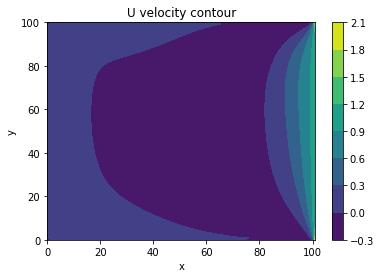

TypeError: Length of x (102) must match number of columns in z (101)

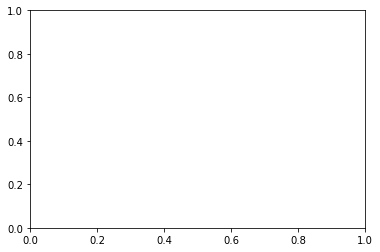

In [10]:
x_u = np.linspace(0, x_len, x_points)
y_u = np.linspace(0, y_len, y_points)
plt.contourf(u_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("U velocity contour")
plt.show()

x_v = np.linspace(0, x_len, x_points)
y_v = np.linspace(0, y_len, y_points+1)
plt.contourf(y_v, x_v, v_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("V velocity contour")
plt.show()

x_p = np.linspace(0, x_len, x_points+1)
y_p = np.linspace(0, y_len, y_points+1)
plt.contourf(y_p, x_p, p_new)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Pressure contour")
plt.show()

In [3]:
u_new.shape

(101, 102)

ValueError: Argument U has a size 102 which does not match 101, the number of arrow positions

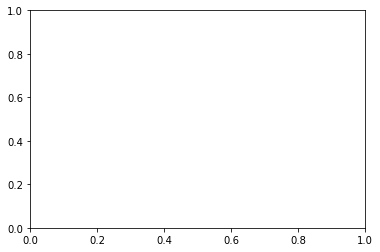

In [4]:
x_u = np.linspace(0, x_len, x_points)
y_u = np.linspace(0, y_len, y_points)
plt.quiver(x_u,y_u,u_new[0],u_new[1])